<a href="https://colab.research.google.com/github/mmonch/Sidecar_Project/blob/main/notebooks/Sidecar_Project_lstm_seq2seq_model_almost_full_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level recurrent sequence-to-sequence model

Source: https://keras.io/examples/nlp/lstm_seq2seq/

## Setup

In [ ]:
!pip install contractions

In [ ]:
# nlp packages
import re
import unicodedata
import contractions
import spacy
import nltk

# progressbar
import tqdm

# general packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Deeplearing
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
# fix random seed for reproducibility
seed = 42

# for numpy
np.random.seed(seed)
# for tenserflow.keras
tf.random.set_seed(seed)

## Download the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv("gdrive/My Drive/SIDECAR_P/Sidecar_Data_Sample.csv")
len(data)

4133

In [ ]:
data = data[data["Attribute_Business_Name"].map(data["Attribute_Business_Name"].value_counts()) > 1]
len(data)

2636

In [ ]:
data["Attribute_Business_Name"].value_counts()

Date and time the record was last updated.    70
Last modified date                            58
Last modified by                              52
Last Edited By                                49
Valid to                                      38
                                              ..
Configuration classification id                2
Config Search id                               2
Audit Classification Config id                 2
Audit classification id                        2
Sidecar Note                                   2
Name: Attribute_Business_Name, Length: 602, dtype: int64

## Train Test Split

Issue #1:
We can't stratify the classes if we have classes with less than two members in the dataset.

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Issue #2: 
The testset must be greater than number of classes!

ValueError: The test_size = 528 should be greater or equal to the number of classes = 602

Therefore I removed any value_counts() under 2 and increased the test_size to 0.3 (from 0.2)

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=42, stratify=data["Attribute_Business_Name"])

In [ ]:
print("Length of Training Set: " + str(len(train)), "\nLength of Test Set: " + str(len(test)))

Length of Training Set: 1845 
Length of Test Set: 791


In [ ]:
print(train.Attribute_Business_Name.value_counts(), test.Attribute_Business_Name.value_counts())

Date and time the record was last updated.                           49
Last modified date                                                   41
Last modified by                                                     36
Last Edited By                                                       34
Valid from                                                           27
                                                                     ..
Birth place                                                           1
Purchase order, sales order, or work order identification number.     1
Typical weight for one unit of this product (packaged)                1
Supplier's bank's international code (such as a SWIFT code)           1
Set index                                                             1
Name: Attribute_Business_Name, Length: 602, dtype: int64 Date and time the record was last updated.    21
Last modified date                            17
Last modified by                              16
Last

## Configurations

In [ ]:
# for plotting
plt.style.use("seaborn")

In [ ]:
# for lstm seq 2 seq model
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Prepare the data

### Preprocess and normalize the data


In [ ]:
# preprocess and normalize Text

# in case text not english
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# preprocessing
def pre_process_text(labels):
  norm_docs = []
  for string in tqdm.tqdm(labels):
    string = string.replace("_", " ")
    string = string.translate(string.maketrans("\n\t\r", "   "))
    string = remove_accented_chars(string) 
    # and inset a space where a number follows a letter et vice versa
    string = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', string)
    # insert space where an uppercase letter follows a lowercase letter
    string = re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", string)
    string = contractions.fix(string)
    # where XXXX number to XXXX number replace - with to IN PROGRESS
    string = string.replace("-", " to ")
    # remove special characters or whitespaces
    string = re.sub(r"[^a-zA-Z0-9\s]", "", string, flags=re.I|re.A)
    string = string.lower()
    string = string.strip()
    # string = string.split(" ")
    norm_docs.append(string)
  return norm_docs

# lemamtization

#def spacy_lemmatize_text(text):
    #text = nlp(text)
    #text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    #return text

### Vectorize the Data

In [ ]:
# vectorize the data

input_texts = pre_process_text(train["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(train["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 1845/1845 [00:00<00:00, 40485.98it/s]

Number of samples: 1845
Number of unique input tokens: 37
Number of unique output tokens: 37
Max sequence length for inputs: 39
Max sequence length for outputs: 94


In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
METRICS = [
  "accuracy",
]


In [ ]:
model.compile(
    optimizer="rmsprop", 
    loss="categorical_crossentropy", 
    metrics=METRICS
)

mc = keras.callbacks.ModelCheckpoint(
    'my_nmt_model_min_loss.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[es]
)

# Save model
model.save("lstm_s2s_v2")

Epoch 1/100
24/24 [==============================] - 28s 69ms/step - loss: 1.2763 - accuracy: 0.7396 - val_loss: 0.9236 - val_accuracy: 0.7877
Epoch 2/100
24/24 [==============================] - 0s 21ms/step - loss: 0.9766 - accuracy: 0.7760 - val_loss: 0.8586 - val_accuracy: 0.7881
Epoch 3/100
24/24 [==============================] - 0s 20ms/step - loss: 0.9029 - accuracy: 0.7766 - val_loss: 0.7914 - val_accuracy: 0.7905
Epoch 4/100
24/24 [==============================] - 0s 20ms/step - loss: 0.8382 - accuracy: 0.7775 - val_loss: 0.7824 - val_accuracy: 0.7898
Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 0.8511 - accuracy: 0.7778 - val_loss: 0.7282 - val_accuracy: 0.7914
Epoch 6/100
24/24 [==============================] - 0s 20ms/step - loss: 0.7663 - accuracy: 0.7793 - val_loss: 0.7507 - val_accuracy: 0.7918
Epoch 7/100
24/24 [==============================] - 0s 20ms/step - loss: 0.7750 - accuracy: 0.7808 - val_loss: 0.7011 - val_accuracy: 0.7919
Epoch

INFO:tensorflow:Assets written to: lstm_s2s_v2/assets


INFO:tensorflow:Assets written to: lstm_s2s_v2/assets


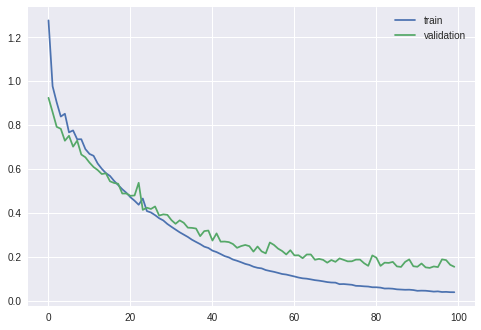

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

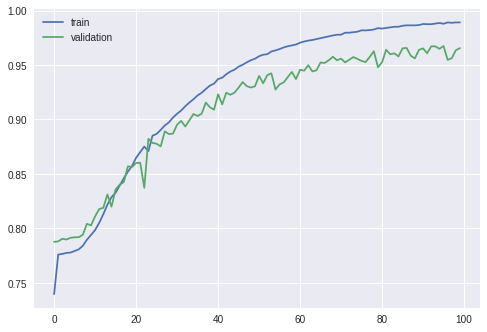

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

## Run Inference on a sample (n=20) of the Training Data

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("lstm_s2s_v2")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    # WHY --> to find that vector in the encoded inputs?
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
    print("True Target sentence:", target_texts[seq_index])

-
Input sentence: update date
Decoded sentence: value as concatton paleg

True Target sentence: 	update date

-
Input sentence: sys last modified
Decoded sentence: last scanned

True Target sentence: 	last modified date

-
Input sentence: p af 189395
Decoded sentence: datetime

True Target sentence: 	datetime

-
Input sentence: audit delete status
Decoded sentence: database statu

True Target sentence: 	status

-
Input sentence: id
Decoded sentence: id patient

True Target sentence: 	id

-
Input sentence: privacy level id
Decoded sentence: provertry teplaited fix tof anial nome

True Target sentence: 	privacy level id

-
Input sentence: attribute id
Decoded sentence: attribute id

True Target sentence: 	attribute id

-
Input sentence: city name
Decoded sentence: country id

True Target sentence: 	formal name of the city

-
Input sentence: attribute business name
Decoded sentence: attribute business description

True Target sentence: 	attribute business name

-
Input sentence: log file 

Run Inference on a sample (n=20) of the Test Data

In [ ]:
# vectorize the data

input_texts = pre_process_text(test["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(test["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 791/791 [00:00<00:00, 43408.28it/s]

Number of samples: 791
Number of unique input tokens: 37
Number of unique output tokens: 37
Max sequence length for inputs: 39
Max sequence length for outputs: 94


In [ ]:
score, acc = model.evaluate(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

13/13 [==============================] - 1s 9ms/step - loss: 0.1050 - accuracy: 0.9738
Test score: 0.10504356026649475
Test accuracy: 0.9737606644630432


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
    print("True Target sentence:", target_texts[seq_index])

-
Input sentence: domain sponsor name
Decoded sentence: domain sponsor contact info

True Target sentence: 	domain sponsor name

-
Input sentence: delivery postal code
Decoded sentence: numeric id used for reference to a payment type within the database

True Target sentence: 	postal code for the company

-
Input sentence: sys last modified
Decoded sentence: last scanned

True Target sentence: 	last modified date

-
Input sentence: attribute id
Decoded sentence: attribute id

True Target sentence: 	attribute id

-
Input sentence: privacy level id
Decoded sentence: provertry teplaited fix tof anial nome

True Target sentence: 	privacy level id

-
Input sentence: asset schema
Decoded sentence: status id

True Target sentence: 	schema

-
Input sentence: valid from
Decoded sentence: valid from this date and time

True Target sentence: 	valid from this date and time

-
Input sentence: asset id
Decoded sentence: asset id

True Target sentence: 	asset id

-
Input sentence: person id
Decoded s